# DILI optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with values of DILI within drug-like region according to Lipinsky rule. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learning for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [1]:
import torch
print(torch.cuda.is_available())

/hpc/group/rekerlab/byz6/miniconda3/envs/generative_models/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./release/')
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

env: CUDA_VISIBLE_DEVICES=1


## Setting up the generator

### Loading data for the generator

In [3]:
gen_data_path = './data/Desalted_Input_Encoded.smi'

In [4]:
#ALL FRAG
tokens = ['<', '>','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
          'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
          '1','2','3','4']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [38]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 2.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=2.0)
    ax.set(xlabel='Predicted Combustion', 
           title='Distribution of predicted Combustion for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Returns valid SMILES and their predicted logPs

In [6]:
def estimate_and_update(generator, predictor, drug, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=25)[1:-1])

#     sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
#     unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(generated, drug, use_tqdm=True)  
    print(len(prediction))
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [7]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [8]:
model_path = './trainedModels/generator/AllFragsEncodedrnn'

In [16]:
losses = my_generator.fit(gen_data,1000)

Training in progress...:  10%|█▌              | 99/1000 [00:09<01:24, 10.65it/s]

 9s (100 10%) 2.7052]
<FHBmecRiUpuspcfdfFHSgqcBggjbjwWeAhfbeIScStnKZCSSBybGJdJ3ND2Iav4MsGGnfdSyfG1ObbLmom2lPGATXMqyczSPaMhD 



Training in progress...:  20%|███            | 200/1000 [00:19<01:18, 10.20it/s]

 19s (200 20%) 2.6830]
<EUkbQqDmNUW4SYep3tXZpoXK2xMFNStBGnhrATOnyzwAT> 



Training in progress...:  30%|████▌          | 302/1000 [00:28<00:53, 13.11it/s]

 28s (300 30%) 2.4064]
<ogqnvGzvlGqGzRAGGSNAlSGNcGzGGGGISMBGzSfnzGnzSnSIzTbcSWGGNGFSGIrGzGnGnGS> 



Training in progress...:  40%|██████         | 401/1000 [00:38<00:57, 10.47it/s]

 38s (400 40%) 2.3519]
<GIIRGnzO> 



Training in progress...:  50%|███████▌       | 501/1000 [00:47<00:53,  9.27it/s]

 47s (500 50%) 1.7558]
<xiLrXGGAtGAGnGSBxSAG> 



Training in progress...:  60%|█████████      | 600/1000 [00:57<00:47,  8.38it/s]

 57s (600 60%) 2.3956]
<GnnSTSzbGnGnzGrGClTSAGGToNznTGrSEnSGnGlSNPzGGPGrzHGPGPGnlSnPGGnGGGnSWGGzGGrGGnGzGnGnPGzPGGGzNGzGrzGn 



Training in progress...:  70%|██████████▌    | 702/1000 [01:07<00:27, 10.86it/s]

 6s (700 70%) 1.8436]
<GGnGgPGSrFS> 



Training in progress...:  80%|████████████   | 801/1000 [01:16<00:19, 10.12it/s]

 16s (800 80%) 1.8231]
<VPZjnxMx> 



Training in progress...:  90%|█████████████▌ | 902/1000 [01:26<00:08, 11.77it/s]

 26s (900 90%) 1.6650]
<bnn3SmaLVTNNClSqTdNTSNNxKrNGnNnSWTSl> 



Training in progress...: 100%|██████████████| 1000/1000 [01:35<00:00, 10.51it/s]

 35s (1000 100%) 2.4283]
<KNiTSa> 



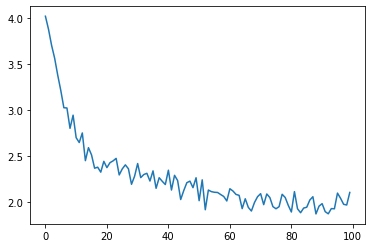

In [17]:
plt.plot(losses)

In [18]:
my_generator.evaluate(gen_data)

'<GRS>'

In [19]:
my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [9]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Recurrent Neural Network, i.e. unidirectional LSTM with 2 layers. The network is trained in 5-fold cross validation manner using the OpenChem toolkit (https://github.com/Mariewelt/OpenChem). In this demo we only upload the pretrained model. The training demo is in *RecurrentQSAR-example-logp.ipynb* file in the same directory. 

In [10]:
#LGBM
from CombustionPredictor import CombustionPredictor
path = 'LBGM_Combustion_81%.pkl'
my_predictor = CombustionPredictor(path,tokens)

In [33]:
selfies = ['']
drug = 'pv'

In [34]:
mol, pred, invalid = my_predictor.predict(selfies, drug)

In [35]:
pred

array([1.29090337])

Here we produce the unbiased distribution of the property:

Generating molecules...: 100%|██████████████| 1000/1000 [00:43<00:00, 22.91it/s]
[11:17:14] Explicit valence for atom # 13 Br, 3, is greater than permitted
[11:17:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[11:17:14] WARNING: not removing hydrogen atom without neighbors
[11:17:14] Explicit valence for atom # 1 Br, 4, is greater than permitted
[11:17:14] Explicit valence for atom # 0 Br, 2, is greater than permitted
[11:17:14] Explicit valence for atom # 4 Br, 3, is greater than permitted
[11:17:14] Explicit valence for atom # 3 Br, 2, is greater than permitted
[11:17:14] WARNING: not removing hydrogen atom without neighbors


994
Percentage of predictions within drug-like region: 0.03722334004024145
Proportion of valid SMILES: 0.994


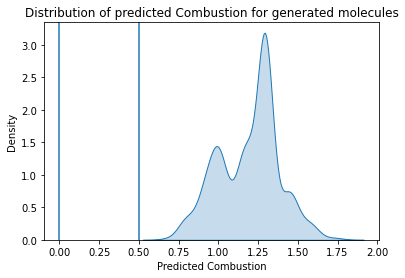

In [37]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           drug,
                                                           n_to_generate=1000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Optimizing logP to be in drug like region

In [39]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [40]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [61]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 10

In [62]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [63]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    drug = ''
    mol, prop, nan_smiles = predictor.predict([smiles],drug)
    if len(nan_smiles) == 1:
        return invalid_reward
    reward = 10*np.tanh(0.8*(prop[0] - 1))
    return reward

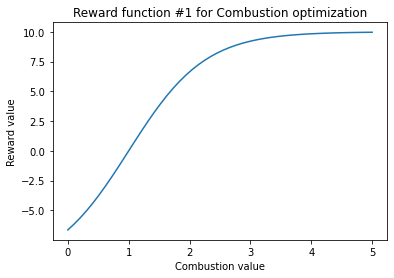

In [64]:
x = np.linspace(0, 5)
reward = lambda x: 10*np.tanh(0.8*(x-1))
plt.plot(x, [reward(i) for i in x])
plt.xlabel('Combustion value')
plt.ylabel('Reward value')
plt.title('Reward function #1 for Combustion optimization')
plt.show()

In [65]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [66]:
rewards = []
rl_losses = []

Policy gradient...: 100%|███████████████████████| 15/15 [00:26<00:00,  1.77s/it]


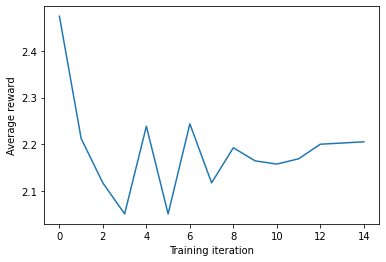

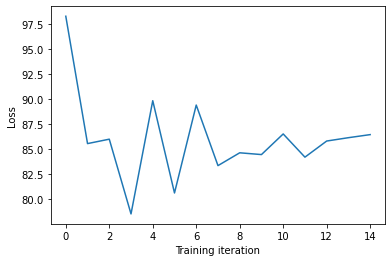

Generating molecules...: 100%|████████████████| 200/200 [00:10<00:00, 19.72it/s]
[11:30:29] Explicit valence for atom # 3 Br, 3, is greater than permitted


199
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.995


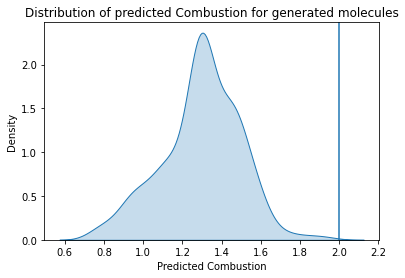

Sample trajectories:
N=[N-1]
NPOCNN
CCCC=O
IN\S#N
CPCCC=O


Policy gradient...: 100%|███████████████████████| 15/15 [00:32<00:00,  2.14s/it]


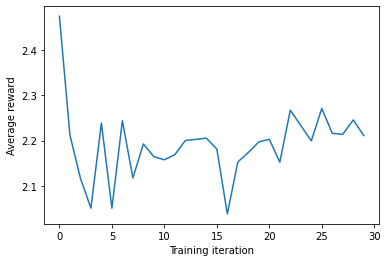

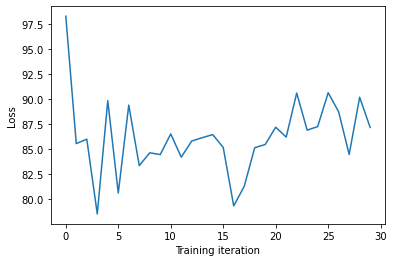

Generating molecules...: 100%|████████████████| 200/200 [00:09<00:00, 20.96it/s]
[11:31:11] Explicit valence for atom # 1 Br, 4, is greater than permitted
[11:31:11] Explicit valence for atom # 0 Br, 4, is greater than permitted
[11:31:11] Explicit valence for atom # 2 Br, 3, is greater than permitted


197
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.985


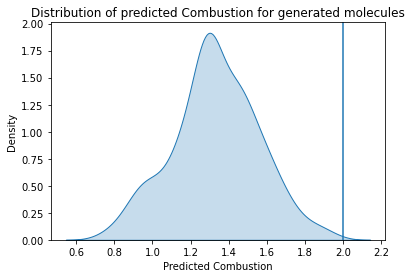

Sample trajectories:
C1N/C(S)\CC=NNCCCCCC1
CCCl
C(C)CC(C1)CC1C
C#C
CC=O


Policy gradient...: 100%|███████████████████████| 15/15 [00:35<00:00,  2.35s/it]


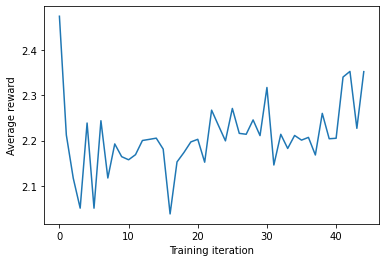

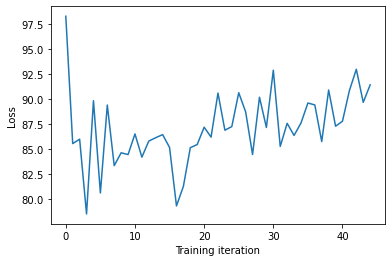

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 24.87it/s]

197
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.985



[11:31:55] Explicit valence for atom # 2 Br, 3, is greater than permitted
[11:31:55] Explicit valence for atom # 1 Br, 4, is greater than permitted
[11:31:55] Explicit valence for atom # 0 Br, 2, is greater than permitted


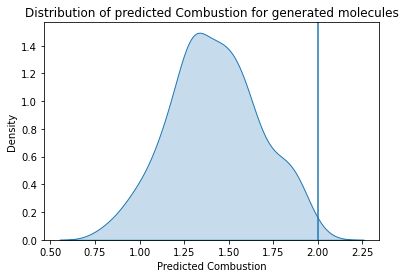

Sample trajectories:
OCCNCCCCCC(C)CC
C=CC(C)(C)OCCCCC(C)CNCCCC
CCCCCCCCCCC(NC=CC)=O
[2H]/O
CCCC=O


Policy gradient...: 100%|███████████████████████| 15/15 [00:44<00:00,  2.95s/it]


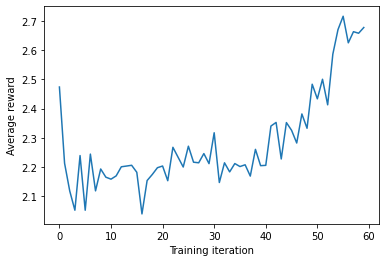

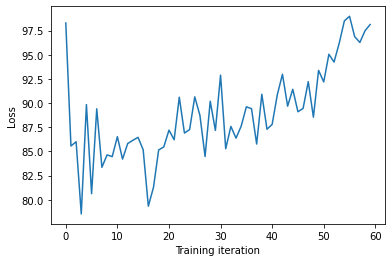

Generating molecules...: 100%|████████████████| 200/200 [00:10<00:00, 18.71it/s]
[11:32:50] WARNING: not removing hydrogen atom without neighbors
[11:32:50] WARNING: not removing hydrogen atom without neighbors


200
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 1.0


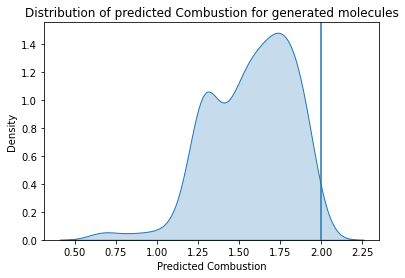

Sample trajectories:
NC=CCCCCC1CCCCC1CC=O
N=CCCCCCCC[C@H1]CCCCCC=NCCCCC
CCCCCC(C)CC[C@@H1]CCCCCCCCNCCC
C[C@]NCCCC(C)CCCCCCCCCC[C@H1]OC
C1CCCC(=N)C1COCCCCCCCCCC


Policy gradient...: 100%|███████████████████████| 15/15 [00:49<00:00,  3.31s/it]


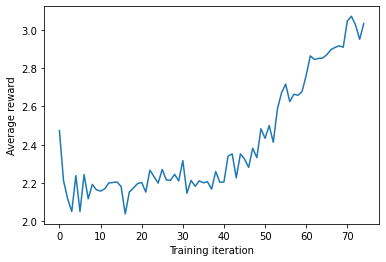

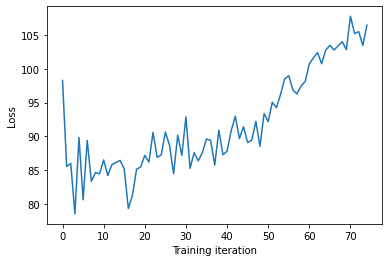

Generating molecules...: 100%|████████████████| 200/200 [00:11<00:00, 16.87it/s]
[11:33:52] Explicit valence for atom # 18 Br, 3, is greater than permitted


199
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.995


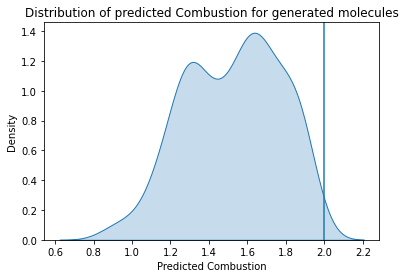

Sample trajectories:
CCCC(C)CCCC(C)CCCCCCC=C
C1CCC(C)C=C1CC=O
CCCOCCCCCCCC(C)(C)CCCN
CCCCC(C)=CCCCNCCCC=CCCOC
CCC=CCOC=CCC


Policy gradient...: 100%|███████████████████████| 15/15 [00:51<00:00,  3.41s/it]


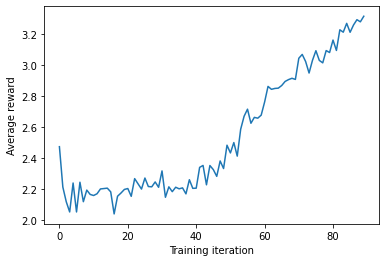

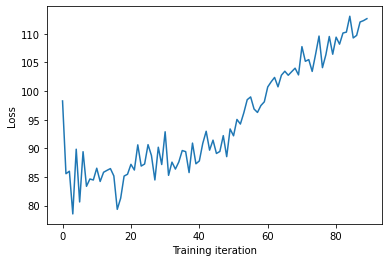

Generating molecules...: 100%|████████████████| 200/200 [00:12<00:00, 15.79it/s]
[11:34:56] Explicit valence for atom # 0 Br, 2, is greater than permitted


199
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.995


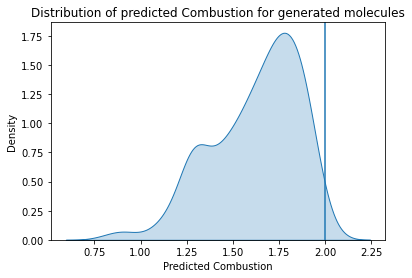

Sample trajectories:
PC[NH1]C\[C@@H1]CCCCCCCC=CCCCCCC

CCCCCCCCCCCCCCCC1C=CCNC1C
CCCCCCCCCCCC(C)C=O
OCCCCCCCOC(N)C(=O)CC


Policy gradient...: 100%|███████████████████████| 15/15 [00:53<00:00,  3.55s/it]


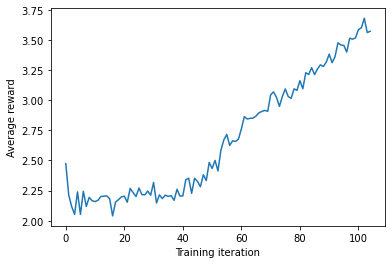

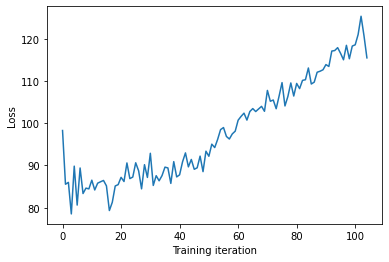

Generating molecules...: 100%|████████████████| 200/200 [00:11<00:00, 17.00it/s]
[11:36:01] Explicit valence for atom # 1 Br, 2, is greater than permitted
[11:36:01] Explicit valence for atom # 12 Br, 4, is greater than permitted
[11:36:01] Explicit valence for atom # 0 Br, 2, is greater than permitted


197
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.985


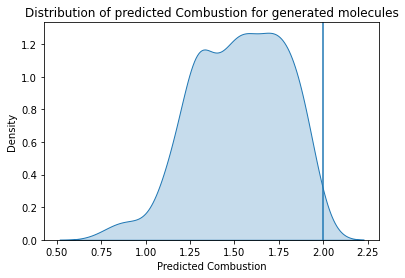

Sample trajectories:
C=NCC#C
CCCCCCCNCC(C)CC(C)CC=NC

CC=O
CC=CC=O


Policy gradient...: 100%|███████████████████████| 15/15 [00:46<00:00,  3.12s/it]


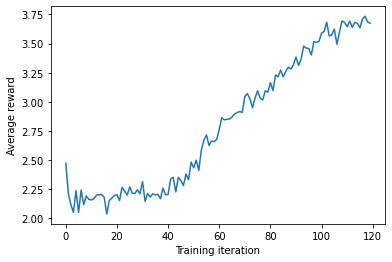

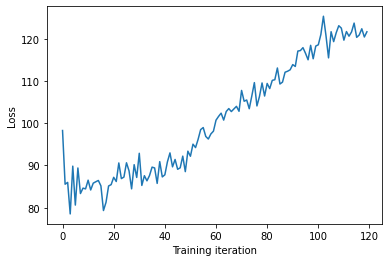

Generating molecules...: 100%|████████████████| 200/200 [00:11<00:00, 17.85it/s]
[11:37:00] Explicit valence for atom # 3 Br, 3, is greater than permitted
[11:37:00] Explicit valence for atom # 3 Br, 2, is greater than permitted
[11:37:00] Explicit valence for atom # 0 Br, 3, is greater than permitted


197
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.985


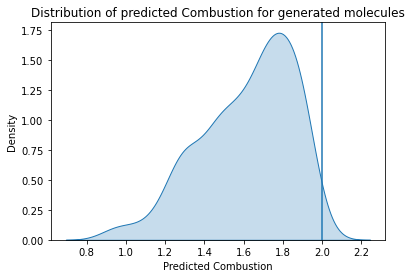

Sample trajectories:
C1CCC1CC=NCOCCC=NC(C)CCCC
N=C
CCCOCCCCNCC(C)CCCCCCCCC
[Si]1\N=NN/S1(C)C(C)CCCCCCCCC
CCCCCCCCCCNCCNCCCCCNC


Policy gradient...: 100%|███████████████████████| 15/15 [00:58<00:00,  3.89s/it]


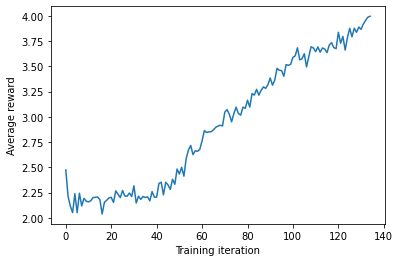

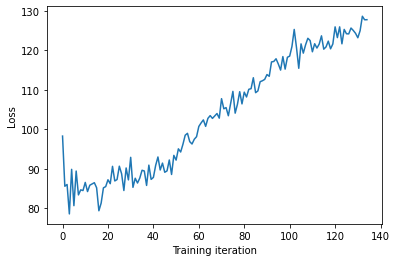

Generating molecules...: 100%|████████████████| 200/200 [00:08<00:00, 24.64it/s]
[11:38:06] Explicit valence for atom # 0 Br, 2, is greater than permitted
[11:38:06] Explicit valence for atom # 11 Br, 2, is greater than permitted


198
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.99


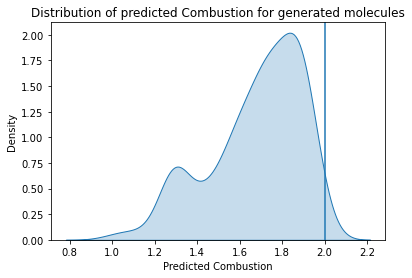

Sample trajectories:
CCCCC1CCCNCCCCCCCCC1C#C
CCCCCCCCCCCCNC=NCCCCCCCCC
CCOCCCCCC=NCCCCCCCCl
CCCCCCCCCCCCCC/CCCCCC
NCCl


Policy gradient...: 100%|███████████████████████| 15/15 [01:00<00:00,  4.05s/it]


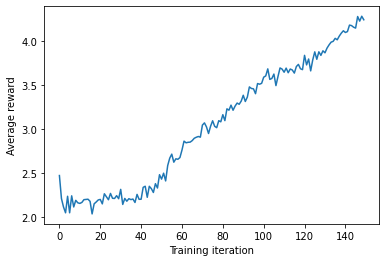

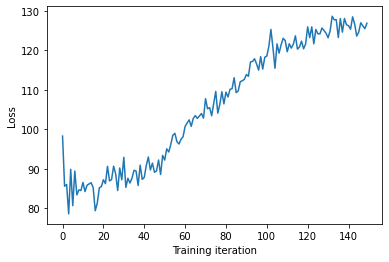

Generating molecules...: 100%|████████████████| 200/200 [00:12<00:00, 16.43it/s]


200
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 1.0


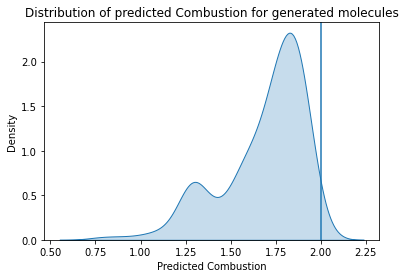

Sample trajectories:
FON=N
CCCCCCCCCCCCNCCCCCCCOCC
CCCCNCCCO[C@@H1]CCC1CCCCCCCC1C
CCCCCCCCC(=O)CCCCNCNCCC=CC
CCNCCCCCCCCC(C)CCCCCC


In [67]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, drug, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

Generating molecules...: 100%|██████████████| 1000/1000 [00:57<00:00, 17.48it/s]
[11:40:20] Explicit valence for atom # 1 Br, 3, is greater than permitted
[11:40:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[11:40:20] Explicit valence for atom # 2 Br, 3, is greater than permitted
[11:40:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[11:40:20] Explicit valence for atom # 0 Br, 3, is greater than permitted
[11:40:20] Explicit valence for atom # 0 Br, 2, is greater than permitted


994
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.994


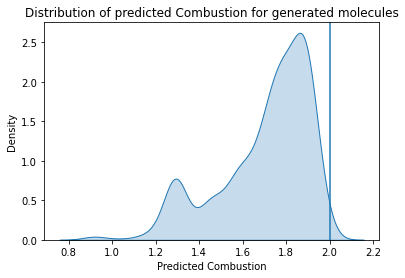

In [68]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       drug,
                                                       n_to_generate=1000)

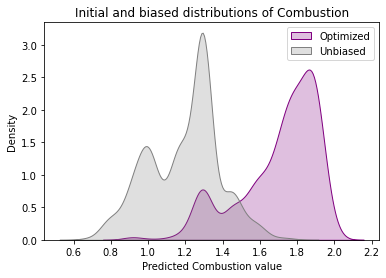

In [69]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted Combustion value')
plt.title('Initial and biased distributions of Combustion')
plt.legend()
plt.show()

### Drawing random molecules

Now we will draw some random compounds from the biased library:

In [148]:
mol, pred, invalid = my_predictor.predictFromSmiles(smiles_biased)

Setting molecule featurization parameters to default.
Loading data


991it [00:00, 164498.78it/s]
100%|█████████████████████████████████████| 991/991 [00:00<00:00, 255914.00it/s]


Validating SMILES
Test size = 991


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]

Saving predictions to None
Elapsed time = 0:00:03


In [149]:
goodDrugsTuple = []
for i in range(len(mol)):
    if pred[i] < 0.5:
        goodDrugsTuple.append((mol[i],pred[i]))

In [150]:
import pandas as pd
goodDrugs = pd.DataFrame(goodDrugsTuple,columns = ['Drug','Pred'])

In [151]:
goodDrugsUniquified = goodDrugs.drop_duplicates()

In [152]:
print('Uniqueness is ' + "%.2f" % (len(goodDrugsUniquified)/len(goodDrugs)))

Uniqueness is 0.98


In [153]:
goodBiasedDrugsUnique = goodDrugsUniquified['Drug'].tolist()
goodBiasedPredsUnique = goodDrugsUniquified['Pred'].tolist()

In [154]:
from rdkit.Chem import Draw

In [155]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [156]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in goodBiasedDrugsUnique] #could use just smiles_biased 

In [157]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [158]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['DILI = ' + str(goodBiasedPredsUnique[i]) for i in ind] #or prediction_biased if all good and bad

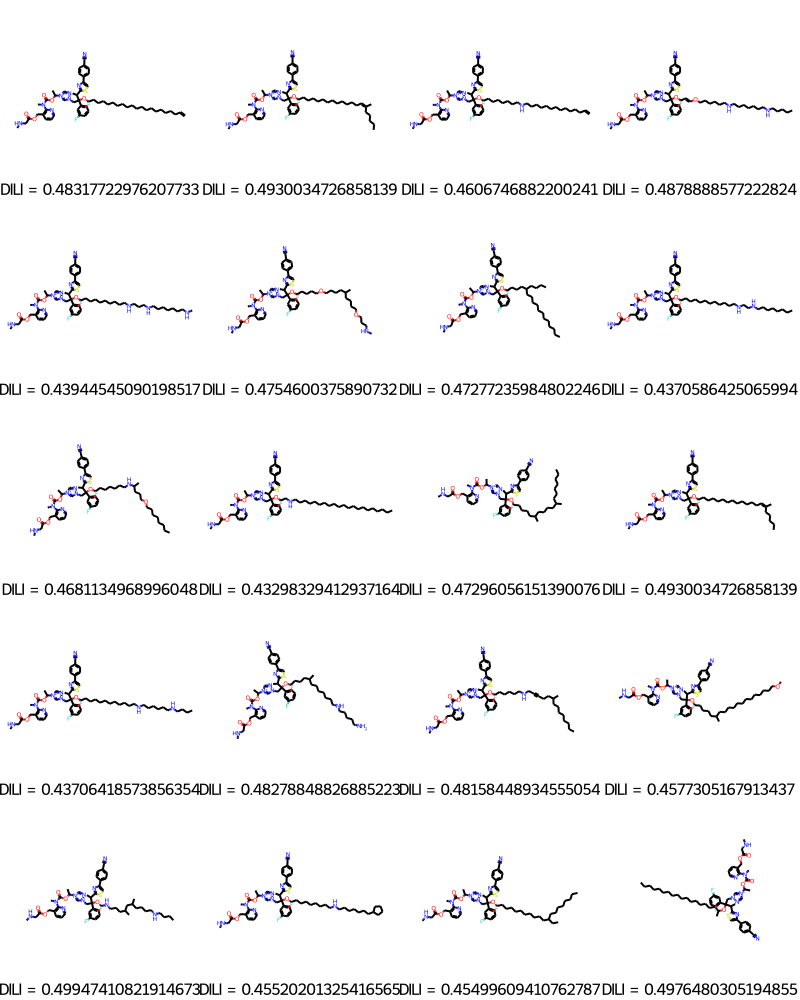

In [159]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, 
                     subImgSize=(200,200), legends=legends)